# Allenamento baseline ResNet50 per Rotazione (Pose Estimation)

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD** con split ufficiale train/test
3. **Inizializza PoseEstimatorBaseline** (ResNet-50 backbone, solo rotazione)
4. **Training**
5. **Valutazione su test set** (solo metriche di rotazione)

Esegui sempre sezione 1 e 2 per configurare l'ambiente. Poi scegli:
- **Training completo**
- **Test modello già trainato -> Punto 5**

## 1. Import e Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
import pandas as pd
import random
import cv2

# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from utils.transforms import quaternion_to_rotation_matrix_batch
from dataset.custom_dataset import create_pose_dataloaders
from models.pose_estimator_baseline import PoseEstimatorBaseline
from utils.bbox_utils import yolo_to_xywh, crop_and_pad

# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Configura matplotlib per notebook
%matplotlib inline

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"🔢 Batch size: {Config.POSE_BATCH_SIZE}")

Cache Strategy: full
Numworkers set to 0
Numworkers set to 0
✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224
🔢 Batch size: 64


## 2. Carica dataset LineMOD

In [3]:
# Carica dataset con split ufficiale train/test
print("📦 Caricamento PoseDataset con split ufficiale...\n")

train_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento PoseDataset con split ufficiale...

🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 3759 train samples
🚀 Cached 13 gt.yml and 13 info.yml files
🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 21218 test samples
🚀 Cached 13 gt.yml and 13 info.yml files

📊 Pose DataLoaders created:
   Training samples: 3759
   Training batches: 59
   Test samples: 21218
   Test batches: 332
✅ Dataset caricato:
   Train batches: 59 (batch_size=64)
   Test batches: 332
   Train samples: ~3776
   Test samples: ~21248
   Crop margin: 15%
   Output size: 224x224
   Workers: 0 (adaptive per mps)


### Visualizza immagini training set con info su rotazione


🖼️  Visualizzazione sample del training set (immagini già croppate)



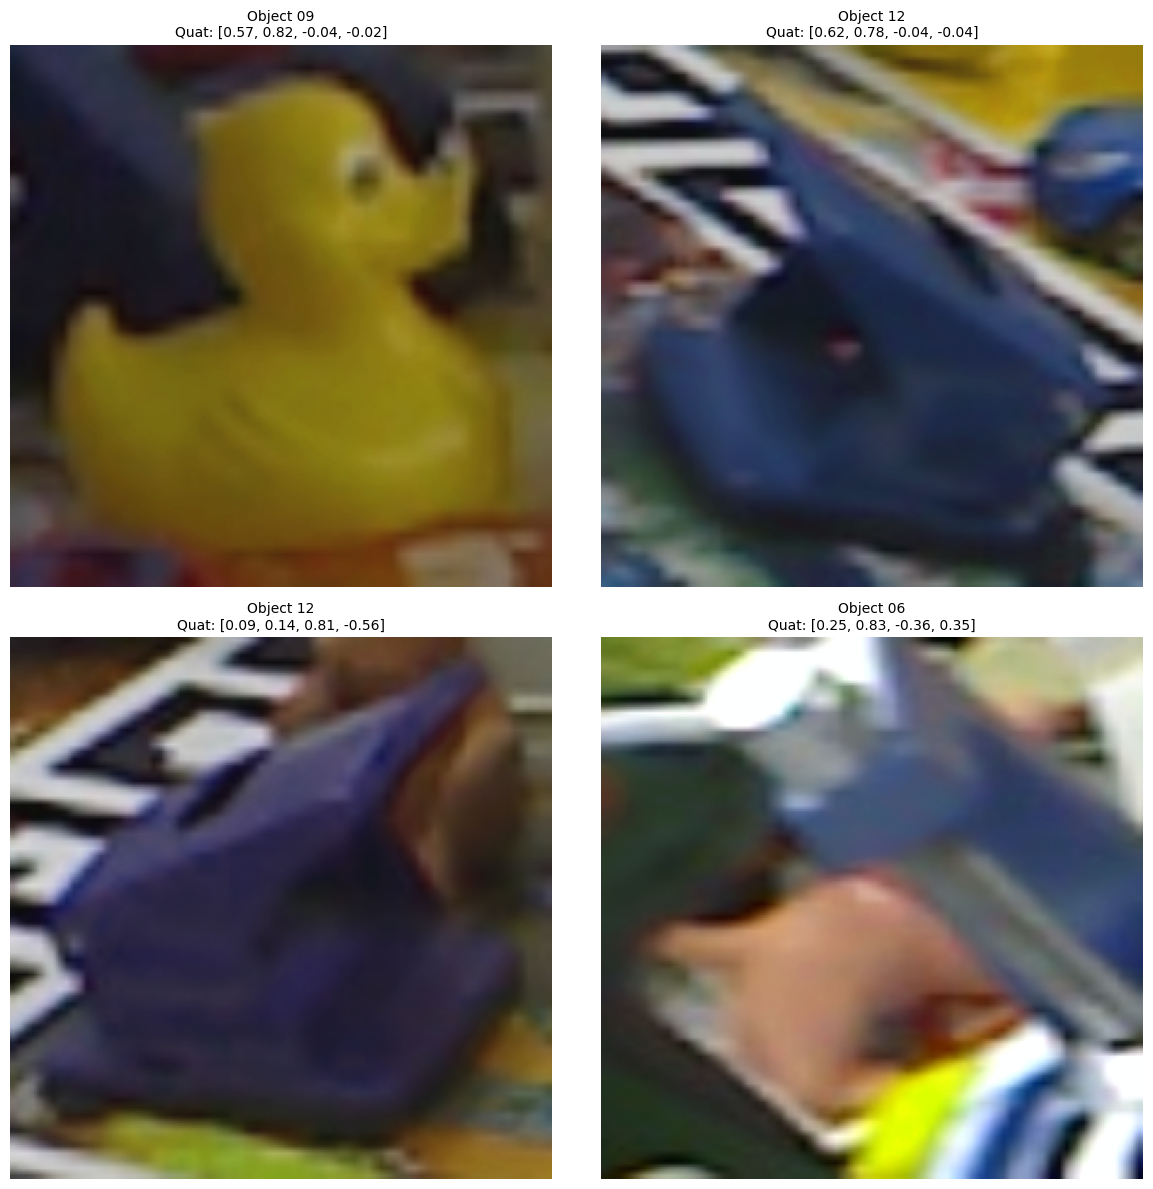

✅ Visualizzazione completata!
   Le immagini sono già croppate dal dataset.
   Quaternion normalizzato (||q|| = 1)


In [6]:
# Visualizza alcuni sample del dataset (le immagini sono già croppate)
print("\n🖼️  Visualizzazione sample del training set (immagini già croppate)\n")
batch = next(iter(train_loader))
images = batch['rgb'] if 'rgb' in batch else batch['rgb_crop']  # [B, 3, H, W] o [B, 3, 224, 224]
quaternions = batch['quaternion']  # [B, 4]
obj_ids = batch['obj_id']  # [B]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i in range(min(4, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    quat = quaternions[i].cpu().numpy()
    obj_id = obj_ids[i].item()
    axes[i].imshow(img)
    axes[i].set_title(
        f"Object {obj_id:02d}\n"
        f"Quat: [{quat[0]:.2f}, {quat[1]:.2f}, {quat[2]:.2f}, {quat[3]:.2f}]",
        fontsize=10
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Visualizzazione completata!")
print(f"   Le immagini sono già croppate dal dataset.")
print(f"   Quaternion normalizzato (||q|| = 1)")

## 3. Inizializza Modello PoseEstimatorBaseline

In [7]:
print("🤖 Inizializzazione PoseEstimatorBaseline...\n")

model = PoseEstimatorBaseline(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
).to(Config.DEVICE)

print(f"✅ Modello inizializzato:")
print(f"   Backbone: ResNet-50 (pretrained ImageNet)")
print(f"   Dropout: {Config.POSE_DROPOUT}")
print(f"   Output: 4D quaternion (rotazione)")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parametri del modello:")
print(f"   Parametri totali: {total_params:,}")
print(f"   Parametri trainable: {trainable_params:,}")
print(f"   Percentuale trainable: {100 * trainable_params / total_params:.1f}%")

🤖 Inizializzazione PoseEstimatorBaseline...



/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5
✅ Modello inizializzato:
   Backbone: ResNet-50 (pretrained ImageNet)
   Dropout: 0.5
   Output: 4D quaternion (rotazione)

📊 Parametri del modello:
   Parametri totali: 26,136,132
   Parametri trainable: 26,136,132
   Percentuale trainable: 100.0%


## 4. Training (solo rotazione)

In [8]:
NAME = f"pose_baseline_train{Config.POSE_EPOCHS}"
EPOCHS = Config.POSE_EPOCHS
LR = 1e-4
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS

# Percorso standardizzato per i pesi
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME / "weights"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
best_path = checkpoint_dir / "best.pt"

from utils.losses import PoseLossBaseline
criterion = PoseLossBaseline()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=Config.POSE_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)

history = {'train_loss': []}
best_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for batch_idx, batch in enumerate(pbar):
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternion = batch['quaternion'].to(Config.DEVICE)
        pred_quaternion = model(images)
        loss_dict = criterion(pred_quaternion, gt_quaternion)
        loss = loss_dict['total'] / ACCUMULATION_STEPS
        loss.backward()
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
        epoch_loss += loss.item() * ACCUMULATION_STEPS
        pbar.set_postfix({'loss': f"{loss.item() * ACCUMULATION_STEPS:.4f}"})
    avg_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_loss)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), best_path)
        print(f"💾 Best model salvato in: {best_path}")
print("✅ Training completato!")

✅ PoseLossBaseline initialized (BASELINE MODEL)
   Loss: Only rotation (quaternion geodesic distance)
   Translation: Computed with Pinhole (not part of loss)


Epoch 1/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.7114]


Epoch 1: loss=0.9799
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 2/50: 100%|██████████| 59/59 [01:02<00:00,  1.05s/it, loss=0.6562]


Epoch 2: loss=0.7055
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 3/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.4793]


Epoch 3: loss=0.5535
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 4/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.4000]


Epoch 4: loss=0.4656
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 5/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.3626]


Epoch 5: loss=0.4097
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 6/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.3960]


Epoch 6: loss=0.3655
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 7/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.3047]


Epoch 7: loss=0.3426
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 8/50: 100%|██████████| 59/59 [00:59<00:00,  1.01s/it, loss=0.3565]


Epoch 8: loss=0.3071
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 9/50: 100%|██████████| 59/59 [00:59<00:00,  1.01s/it, loss=0.2658]


Epoch 9: loss=0.3084


Epoch 10/50: 100%|██████████| 59/59 [00:59<00:00,  1.01s/it, loss=0.2551]


Epoch 10: loss=0.2853
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 11/50: 100%|██████████| 59/59 [00:59<00:00,  1.01s/it, loss=0.2353]


Epoch 11: loss=0.2635
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 12/50: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=0.2173]


Epoch 12: loss=0.2566
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 13/50: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=0.2111]


Epoch 13: loss=0.2384
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 14/50: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=0.2210]


Epoch 14: loss=0.2337
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 15/50: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=0.2533]


Epoch 15: loss=0.2370


Epoch 16/50: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=0.2592]


Epoch 16: loss=0.2459


Epoch 17/50: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=0.2460]


Epoch 17: loss=0.2322
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 18/50: 100%|██████████| 59/59 [00:59<00:00,  1.02s/it, loss=0.2392]


Epoch 18: loss=0.2153
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 19/50: 100%|██████████| 59/59 [00:59<00:00,  1.01s/it, loss=0.2255]


Epoch 19: loss=0.2186


Epoch 20/50: 100%|██████████| 59/59 [00:59<00:00,  1.01s/it, loss=0.2086]


Epoch 20: loss=0.2133
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 21/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.2277]


Epoch 21: loss=0.2103
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 22/50: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=0.1914]


Epoch 22: loss=0.2173


Epoch 23/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.2839]


Epoch 23: loss=0.2248


Epoch 24/50: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=0.2239]


Epoch 24: loss=0.2424


Epoch 25/50: 100%|██████████| 59/59 [00:59<00:00,  1.01s/it, loss=0.2112]


Epoch 25: loss=0.2096
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 26/50: 100%|██████████| 59/59 [00:58<00:00,  1.02it/s, loss=0.2506]


Epoch 26: loss=0.2001
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 27/50: 100%|██████████| 59/59 [00:57<00:00,  1.02it/s, loss=0.2235]


Epoch 27: loss=0.2013


Epoch 28/50: 100%|██████████| 59/59 [00:57<00:00,  1.02it/s, loss=0.1939]


Epoch 28: loss=0.2020


Epoch 29/50: 100%|██████████| 59/59 [00:57<00:00,  1.02it/s, loss=0.2660]


Epoch 29: loss=0.2147


Epoch 30/50: 100%|██████████| 59/59 [00:57<00:00,  1.02it/s, loss=0.3326]


Epoch 30: loss=0.2573


Epoch 31/50: 100%|██████████| 59/59 [00:57<00:00,  1.02it/s, loss=0.2193]


Epoch 31: loss=0.2613


Epoch 32/50: 100%|██████████| 59/59 [00:58<00:00,  1.01it/s, loss=0.2388]


Epoch 32: loss=0.2699


Epoch 33/50: 100%|██████████| 59/59 [00:59<00:00,  1.00s/it, loss=0.2708]


Epoch 33: loss=0.2583


Epoch 34/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.2046]


Epoch 34: loss=0.2566


Epoch 35/50: 100%|██████████| 59/59 [01:01<00:00,  1.03s/it, loss=0.2675]


Epoch 35: loss=0.2463


Epoch 36/50: 100%|██████████| 59/59 [00:59<00:00,  1.01s/it, loss=0.1887]


Epoch 36: loss=0.2362


Epoch 37/50: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=0.2590]


Epoch 37: loss=0.2242


Epoch 38/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=0.2030]


Epoch 38: loss=0.2276


Epoch 39/50: 100%|██████████| 59/59 [01:03<00:00,  1.08s/it, loss=0.2364]


Epoch 39: loss=0.2155


Epoch 40/50: 100%|██████████| 59/59 [01:02<00:00,  1.05s/it, loss=0.1919]


Epoch 40: loss=0.2087


Epoch 41/50: 100%|██████████| 59/59 [01:02<00:00,  1.05s/it, loss=0.1865]


Epoch 41: loss=0.1989
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 42/50: 100%|██████████| 59/59 [01:02<00:00,  1.05s/it, loss=0.1861]


Epoch 42: loss=0.2052


Epoch 43/50: 100%|██████████| 59/59 [01:02<00:00,  1.05s/it, loss=0.2113]


Epoch 43: loss=0.2125


Epoch 44/50: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=0.2075]


Epoch 44: loss=0.1972
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 45/50: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=0.1509]


Epoch 45: loss=0.1955
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 46/50: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=0.1730]


Epoch 46: loss=0.1839
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 47/50: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=0.1861]


Epoch 47: loss=0.1859


Epoch 48/50: 100%|██████████| 59/59 [01:02<00:00,  1.05s/it, loss=0.2231]


Epoch 48: loss=0.1862


Epoch 49/50: 100%|██████████| 59/59 [01:02<00:00,  1.05s/it, loss=0.2050]


Epoch 49: loss=0.1826
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt


Epoch 50/50: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=0.2199]

Epoch 50: loss=0.1845
✅ Training completato!


## 5. Test e Valutazione su sample del Test Set (solo rotazione)

✅ Modello caricato da /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_baseline_train50/weights/best.pt e in modalità eval!


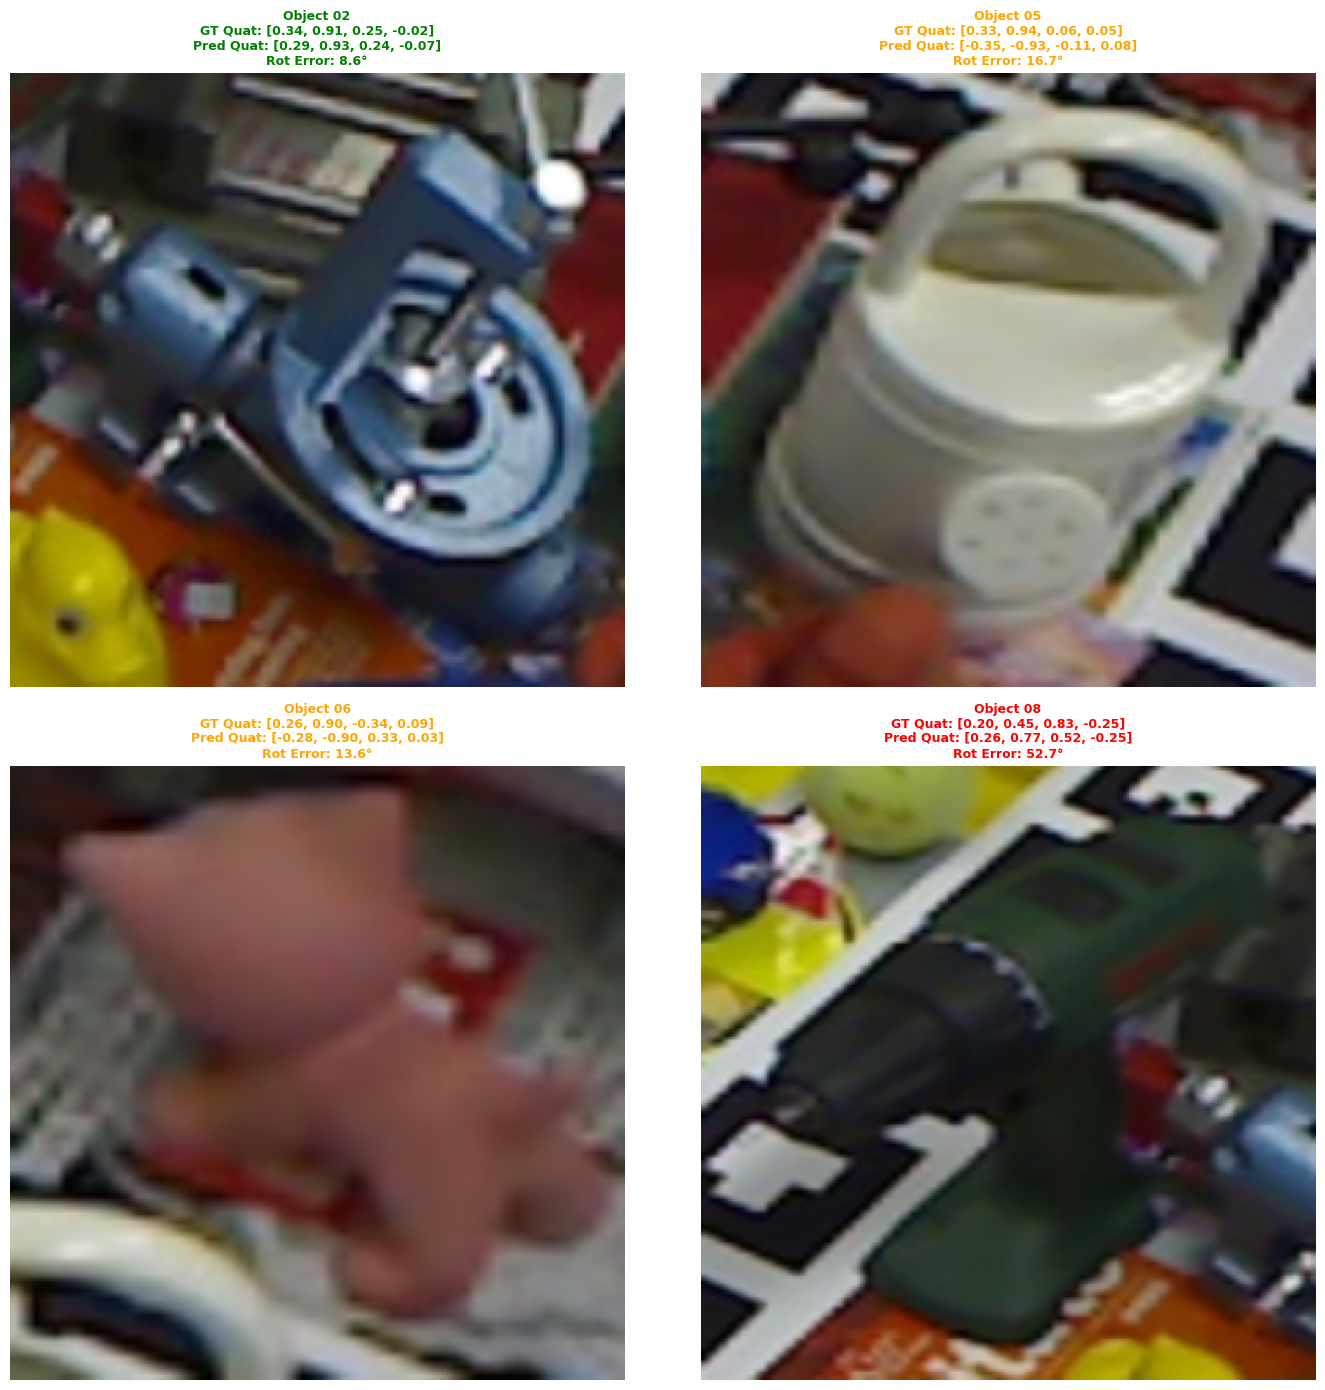

✅ Test completato su 64 sample

📊 Errori medi sul batch:
   Rotation error: 28.17 ± 24.02°


In [9]:
# Carica il modello trained (se necessario)
NAME = f"pose_baseline_train{Config.POSE_EPOCHS}"
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME / "weights"
best_path = checkpoint_dir / "best.pt"
try:
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.eval()
    print(f"✅ Modello caricato da {best_path} e in modalità eval!")
except Exception as e:
    print(f"⚠️  Modello non trovato o già caricato. Errore: {e}")

# Test su batch casuale del test set
random_batch_idx = random.randint(0, len(test_loader) - 1)
for idx, batch in enumerate(test_loader):
    if idx == random_batch_idx:
        test_batch = batch
        break

images = test_batch['rgb_crop'].to(Config.DEVICE)
gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
obj_ids = test_batch['obj_id']

with torch.no_grad():
    pred_quaternions = model(images)

# Calcola rotation error (geodesic distance)
dot_products = torch.sum(pred_quaternions * gt_quaternions, dim=1)
dot_products = torch.clamp(torch.abs(dot_products), 0, 1)
rot_errors = 2 * torch.acos(dot_products) * 180 / np.pi  # In gradi
rot_errors = rot_errors.cpu().numpy()

# Visualizza 4 sample
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()
for i in range(min(4, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    gt_q = gt_quaternions[i].cpu().numpy()
    pred_q = pred_quaternions[i].cpu().numpy()
    obj_id = obj_ids[i].item()
    axes[i].imshow(img)
    title = (
        f"Object {obj_id:02d}\n"
        f"GT Quat: [{gt_q[0]:.2f}, {gt_q[1]:.2f}, {gt_q[2]:.2f}, {gt_q[3]:.2f}]\n"
        f"Pred Quat: [{pred_q[0]:.2f}, {pred_q[1]:.2f}, {pred_q[2]:.2f}, {pred_q[3]:.2f}]\n"
        f"Rot Error: {rot_errors[i]:.1f}°"
    )
    color = 'green' if rot_errors[i] < 10 else 'orange' if rot_errors[i] < 20 else 'red'
    axes[i].set_title(title, fontsize=9, color=color, fontweight='bold')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print(f"✅ Test completato su {len(images)} sample")
print(f"\n📊 Errori medi sul batch:")
print(f"   Rotation error: {rot_errors.mean():.2f} ± {rot_errors.std():.2f}°")